In [1]:
import pickle
import pandas as pd
import spacy
import re
from time import time
import multiprocessing

# Embedding model trainings

### Embed company descriptions

#### Import Data

In [2]:
company_df = pd.read_csv("data/company_desc_translated.csv", sep=";")[["company_name", "description_en"]]

In [3]:
company_df

,company_name,description_en
0,Le Fourgon,Le Fourgon delivers your stored drinks to your...
1,Comptoir des Vignes,Comptoir des Vignes is a brand of cellars spec...
2,Shin Sekai,Welcome to our Trustpilot page! Shin Sekai is ...
3,Nutri Naturel,"Nutri-Naturel.com, the leading online organic ..."
4,Maison Martin - Le Piment Français,Maison Martin - Le Piment Francais is the firs...
...,...,...
12991,Ljbautoparts,"Sale of auto body spare parts online: fender, ..."
12992,Aéroports de Paris,"Aeroports de Paris, with its three platforms, ..."
12993,Online SAS,"Shared hosting with unlimited traffic, domain ..."
12994,shopequitation,Online specialist in the sale of horse riding ...


### Data Cleaning

In [4]:
nlp = spacy.load("en_core_web_sm") 

In [5]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop and len(token.text) > 2]

    if len(txt) > 2:
        return ' '.join(txt)

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in company_df['description_en'])

In [7]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

In [8]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(11365, 1)

In [9]:
df_clean

,clean
0,fourgon deliver store drink home order place l...
1,comptoir des vigne brand cellar specialize win...
2,welcome trustpilot page shin sekai online figu...
3,nutri naturel com lead online organic grocery ...
4,maison martin piment francais brand artisanal ...
...,...
12991,sale auto body spare part online fender bumper...
12992,aeroport paris platform major connection point...
12993,share host unlimited traffic domain dedicated ...
12994,online specialist sale horse ride equipment sa...


In [10]:
df_clean.head(1).values

array([['fourgon deliver store drink home order place lefourgon com beers juice sodas water milk wine soup spirit deliver home free charge choose niche visit collect bottle return wash producer reuse zerodechet']],
      dtype=object)

There is a gensim.models.phrases module which lets you automatically detect phrases longer than one word, using collocation statistics. Using phrases, you can learn a word2vec model where “words” are actually multiword expressions, such as new_york_times or financial_crisis:

In [11]:
from gensim.models.phrases import Phrases, Phraser

In [12]:
sent = [row.split() for row in df_clean['clean']]

In [13]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [14]:
bigram = Phraser(phrases)

In [15]:
sentences = bigram[sent]

In [16]:
sentences[0]

['fourgon',
 'deliver',
 'store',
 'drink',
 'home',
 'order',
 'place',
 'lefourgon',
 'com',
 'beers',
 'juice',
 'sodas',
 'water',
 'milk',
 'wine',
 'soup',
 'spirit',
 'deliver_home',
 'free_charge',
 'choose',
 'niche',
 'visit',
 'collect',
 'bottle',
 'return',
 'wash',
 'producer',
 'reuse',
 'zerodechet']

In [17]:
from collections import defaultdict 

In [18]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

26671

In [19]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['offer',
 'product',
 'service',
 'france',
 'find',
 'quality',
 'good',
 'brand',
 'online',
 'support']

In [20]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

16

#### Word2Vec

In [21]:
from gensim.models import Word2Vec

In [22]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [23]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [24]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4256241, 11171640)

In [25]:
similar_words = w2v_model.wv.most_similar(positive=["wine"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

champagne: 0.9071112871170044
winegrower: 0.8780471682548523
whiskey: 0.8568439483642578
estate: 0.8373821973800659
cellar: 0.8195011615753174
spirit: 0.8164159059524536
rum: 0.7732952237129211
terroir: 0.7704671621322632
tasting: 0.7636184096336365
vineyard: 0.7560701966285706


Save model

In [38]:
# w2v_model.save("models/w2v_company_desc_model")

#### Fasttext

In [27]:
from gensim.models import FastText

In [28]:
fasttext_model = FastText(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [29]:
fasttext_model.build_vocab(sentences, progress_per=10000)

In [30]:
fasttext_model.train(sentences, total_examples=fasttext_model.corpus_count, epochs=30, report_delay=1)

(4256514, 11171640)

In [31]:
# fasttext_model.save("models/fasttext_model")

In [32]:
similar_words = fasttext_model.wv.most_similar(positive=["manga"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

comic_strip: 0.8654958009719849
pop: 0.8409628868103027
figurine: 0.8253823518753052
goody: 0.7767293453216553
geek: 0.7636668086051941
pokemon: 0.7519635558128357
series: 0.7490500807762146
fan: 0.7174332141876221
games: 0.715712308883667
video_game: 0.7139608860015869


#### GloVe Transfer Learning

Load the Glove Model

In [33]:
import gensim.downloader

In [34]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [35]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [36]:
glove_vectors.most_similar('product')

[('products', 0.78656005859375),
 ('brand', 0.5952008366584778),
 ('marketing', 0.574771523475647),
 ('sales', 0.5687329769134521),
 ('consumer', 0.5489877462387085),
 ('brands', 0.5295148491859436),
 ('growth', 0.5233907699584961),
 ('quality', 0.5170866847038269),
 ('manufacturers', 0.5161595940589905),
 ('components', 0.5161356925964355)]

Train a base Model we can get the Word2Vec trained previously

In [39]:
base_model = Word2Vec.load('models/w2v_company_desc_model')

Sanity check

In [40]:
similar_words = base_model.wv.most_similar(positive=["wine"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

champagne: 0.9071112871170044
winegrower: 0.8780471682548523
whiskey: 0.8568439483642578
estate: 0.8373821973800659
cellar: 0.8195011615753174
spirit: 0.8164159059524536
rum: 0.7732952237129211
terroir: 0.7704671621322632
tasting: 0.7636184096336365
vineyard: 0.7560701966285706


ADD GLOVE WEIGHTS AND RETRAIN

In [70]:
glove_vectors.key_to_index

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

In [69]:
len(glove_vectors.key_to_index)

400000

In [66]:
list(glove_vectors.key_to_index.keys())

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 

In [42]:
# add GloVe's vocabulary & weights
base_model.build_vocab([list(glove_vectors.key_to_index)], update=True)

In [43]:
base_model.train(sentences, total_examples=base_model.corpus_count, epochs=30, report_delay=1)

(4256434, 11171640)

In [44]:
base_model.save("models/glove_transfer")

Glove Transfer Learning Word2Vec

In [45]:
similar_words = base_model.wv.most_similar(positive=["product"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

high_quality: 0.7024643421173096
carefully_select: 0.6490936279296875
cosmetic: 0.6490697860717773
competitive_price: 0.642071545124054
food: 0.6345551609992981
attractive_price: 0.6285368204116821
price_ratio: 0.624824047088623
food_supplement: 0.6131947636604309
quality: 0.6063768267631531
select: 0.6040136814117432


Word2Vec

In [46]:
similar_words = w2v_model.wv.most_similar(positive=["product"])
for word, similarity in similar_words:
    print(f"{word}: {similarity}")

high_quality: 0.7264878153800964
competitive_price: 0.7203394174575806
carefully_select: 0.7093702554702759
aquarium: 0.6818522214889526
rigorously: 0.6766020059585571
assortment: 0.672893226146698
wide_range: 0.6702432632446289
parapharmacy: 0.6621663570404053
select: 0.661758303642273
cosmetic: 0.6563809514045715


### Exploring the Models

Adapted the code from this kaggle: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

#### Word2vec

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [65]:
list(w2v_model.wv.key_to_index.keys())

['offer',
 'product',
 'service',
 'france',
 'find',
 'quality',
 'good',
 'brand',
 'online',
 'support',
 'professional',
 'company',
 'create',
 'french',
 'customer',
 'discover',
 'design',
 'work',
 'site',
 'help',
 'allow',
 'team',
 'year',
 'home',
 'sale',
 'new',
 'solution',
 'world',
 'com',
 'order',
 'store',
 'need',
 'business',
 'free',
 'experience',
 'equipment',
 'provide',
 'thank',
 'accessory',
 'project',
 'range',
 'training',
 'unique',
 'specialize',
 'specialist',
 'day',
 'guarantee',
 'available',
 'natural',
 'paris',
 'expert',
 'life',
 'etc',
 'base',
 'time',
 'real_estate',
 'market',
 'price',
 'creation',
 'website',
 'platform',
 'purchase',
 'jewelry',
 'want',
 'management',
 'care',
 'advice',
 'know',
 'digital',
 'rental',
 'choose',
 'benefit',
 'delivery',
 'develop',
 'contact',
 'people',
 'look',
 'choice',
 'tool',
 'insurance',
 'collection',
 'child',
 'simple',
 'reference',
 'online_store',
 'travel',
 'selection',
 'web',
 'hour

In [112]:
w2v_model.wv[w2v_model.wv.key_to_index.keys()]

array([[ 0.30238196, -0.06739365, -0.10694609, ...,  0.05334571,
         0.04610368, -0.02231845],
       [ 0.14590293, -0.08731528, -0.03648893, ...,  0.05462435,
        -0.28212568, -0.46961787],
       [ 0.2689467 ,  0.00657476, -0.05385301, ...,  0.26041266,
        -0.01005498, -0.14975053],
       ...,
       [ 0.01152079,  0.3759794 ,  0.09457865, ..., -0.23723508,
        -0.11760129, -0.01370526],
       [ 0.09878822,  0.05638697, -0.05612117, ..., -0.01759411,
         0.10377257, -0.09113482],
       [ 0.02455842, -0.08993562,  0.07327648, ...,  0.01163955,
        -0.08052769,  0.05796107]], dtype=float32)

In [75]:
X = w2v_model.wv[w2v_model.wv.key_to_index.keys()]

In [76]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [92]:
result_df = pd.DataFrame(result, columns=["x", "y"])

In [93]:
result_df

,x,y
0,0.054227,0.130202
1,0.986039,0.191858
2,-1.497501,0.899376
3,0.221324,0.860762
4,0.761886,0.432645
...,...,...
2716,2.314226,0.199335
2717,-1.226434,0.211215
2718,0.358175,0.645111
2719,0.161553,-0.327456


In [95]:
result_df["word"] = list(w2v_model.wv.key_to_index.keys())

In [96]:
result_df

,x,y,word
0,0.054227,0.130202,offer
1,0.986039,0.191858,product
2,-1.497501,0.899376,service
3,0.221324,0.860762,france
4,0.761886,0.432645,find
...,...,...,...
2716,2.314226,0.199335,embroider
2717,-1.226434,0.211215,regulate
2718,0.358175,0.645111,plaque
2719,0.161553,-0.327456,notably


In [100]:
import plotly.graph_objects as go

In [104]:
fig = go.Figure(data=go.Scatter(x=result_df['x'],
                                y=result_df['y'],
                                mode='markers',
                                text=result_df['word'])) # hover text goes here

fig.update_layout(width=1500 ,height=1000)
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'text': array(['offer', 'product', 'service', ..., 'plaque', 'notably', 'sort'],
                            dtype=object),
              'type': 'scatter',
              'x': array([ 0.0542274 ,  0.9860386 , -1.4975011 , ...,  0.35817456,  0.16155261,
                           0.14399704], dtype=float32),
              'y': array([ 0.130202  ,  0.19185841,  0.8993764 , ...,  0.6451114 , -0.32745588,
                           0.18050845], dtype=float32)}],
    'layout': {'height': 1000, 'template': '...', 'width': 1500}
})

In [105]:
X2 = base_model.wv[base_model.wv.key_to_index.keys()]

In [106]:
pca = PCA(n_components=2)
result = pca.fit_transform(X2)

In [107]:
result_df = pd.DataFrame(result, columns=["x", "y"])

In [109]:
result_df["word"] = list(base_model.wv.key_to_index.keys())

In [110]:
result_df

,x,y,word
0,0.171496,0.110636,offer
1,1.085017,0.331541,product
2,-1.458723,0.759371,service
3,0.428776,0.819381,france
4,1.046843,0.556090,find
...,...,...,...
2716,2.337973,0.321856,embroider
2717,-0.980753,0.042810,regulate
2718,0.328928,0.741798,plaque
2719,0.194302,-0.547990,notably


In [111]:
fig = go.Figure(data=go.Scatter(x=result_df['x'],
                                y=result_df['y'],
                                mode='markers',
                                text=result_df['word'])) # hover text goes here

fig.update_layout(width=1500 ,height=1000)
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'text': array(['offer', 'product', 'service', ..., 'plaque', 'notably', 'sort'],
                            dtype=object),
              'type': 'scatter',
              'x': array([ 0.17149578,  1.085017  , -1.4587226 , ...,  0.32892838,  0.19430172,
                          -0.04107581], dtype=float32),
              'y': array([ 0.11063579,  0.3315411 ,  0.75937074, ...,  0.741798  , -0.54798985,
                           0.101255  ], dtype=float32)}],
    'layout': {'height': 1000, 'template': '...', 'width': 1500}
})

In [113]:
tsne = TSNE(n_components=2, verbose=1,n_iter=1000,random_state=1)

tsne_results = tsne.fit_transform(w2v_model.wv[w2v_model.wv.key_to_index.keys()])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2721 samples in 0.000s...
[t-SNE] Computed neighbors for 2721 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2721
[t-SNE] Computed conditional probabilities for sample 2000 / 2721
[t-SNE] Computed conditional probabilities for sample 2721 / 2721
[t-SNE] Mean sigma: 1.171348
[t-SNE] KL divergence after 100 iterations with early exaggeration: 80.085388
[t-SNE] KL divergence after 1000 iterations: 1.970271


In [114]:
tsne_results

array([[ -1.7407345 ,  11.368201  ],
       [  0.27321067,  14.011121  ],
       [-19.317757  ,   2.4042587 ],
       ...,
       [ 22.919706  ,  10.054973  ],
       [  0.25020564,  -5.760426  ],
       [ -9.478792  ,   4.0693555 ]], dtype=float32)

In [115]:
tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])
tsne_df["word"] = list(w2v_model.wv.key_to_index.keys())

In [118]:
tsne_df

,x,y,word
0,-1.740734,11.368201,offer
1,0.273211,14.011121,product
2,-19.317757,2.404259,service
3,-13.688169,26.825180,france
4,9.477393,10.031038,find
...,...,...,...
2716,27.803082,5.821275,embroider
2717,-24.316196,-14.826818,regulate
2718,22.919706,10.054973,plaque
2719,0.250206,-5.760426,notably


In [119]:
fig = go.Figure(data=go.Scatter(x=tsne_df['x'],
                                y=tsne_df['y'],
                                mode='markers',
                                text=tsne_df['word'])) # hover text goes here

fig.update_layout(width=1500 ,height=1000)
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'text': array(['offer', 'product', 'service', ..., 'plaque', 'notably', 'sort'],
                            dtype=object),
              'type': 'scatter',
              'x': array([ -1.7407345 ,   0.27321067, -19.317757  , ...,  22.919706  ,
                            0.25020564,  -9.478792  ], dtype=float32),
              'y': array([11.368201 , 14.011121 ,  2.4042587, ..., 10.054973 , -5.760426 ,
                           4.0693555], dtype=float32)}],
    'layout': {'height': 1000, 'template': '...', 'width': 1500}
})

In [120]:
tsne = TSNE(n_components=2, verbose=1,n_iter=1000,random_state=1)

tsne_results = tsne.fit_transform(base_model.wv[base_model.wv.key_to_index.keys()])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2721 samples in 0.001s...
[t-SNE] Computed neighbors for 2721 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2721
[t-SNE] Computed conditional probabilities for sample 2000 / 2721
[t-SNE] Computed conditional probabilities for sample 2721 / 2721
[t-SNE] Mean sigma: 1.286636
[t-SNE] KL divergence after 50 iterations with early exaggeration: 79.868759
[t-SNE] KL divergence after 1000 iterations: 2.052334


In [121]:
tsne_df = pd.DataFrame(tsne_results, columns=["x", "y"])
tsne_df["word"] = list(w2v_model.wv.key_to_index.keys())

In [122]:
fig = go.Figure(data=go.Scatter(x=tsne_df['x'],
                                y=tsne_df['y'],
                                mode='markers',
                                text=tsne_df['word'])) # hover text goes here

fig.update_layout(width=1500 ,height=1000)
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'text': array(['offer', 'product', 'service', ..., 'plaque', 'notably', 'sort'],
                            dtype=object),
              'type': 'scatter',
              'x': array([ -4.973252 ,  -5.4709997, -20.397373 , ...,  25.153091 ,   4.808827 ,
                           -4.178209 ], dtype=float32),
              'y': array([14.752533 , 16.870502 , -1.4672761, ..., 29.628086 , -7.280393 ,
                          -2.159805 ], dtype=float32)}],
    'layout': {'height': 1000, 'template': '...', 'width': 1500}
})

In [48]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)
    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

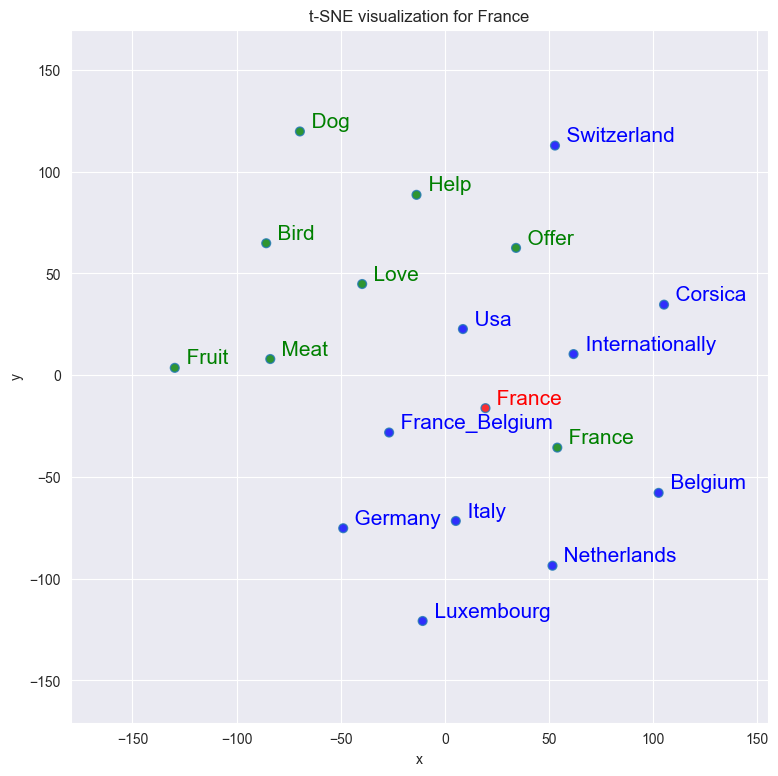

In [123]:
tsnescatterplot(w2v_model, 'france', ['dog', 'bird', 'offer', 'help', 'france', 'fruit', 'meat', 'love'])

#### FastText

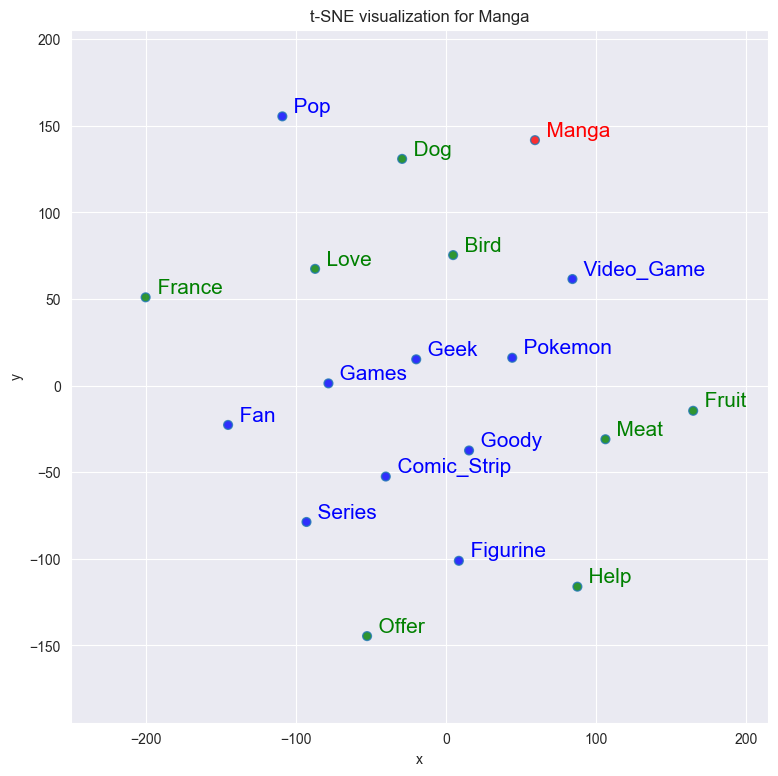

In [55]:
tsnescatterplot(fasttext_model, 'manga', ['dog', 'bird', 'offer', 'help', 'france', 'fruit', 'meat', 'love'])

#### Glove Transfer Word2Vec Model

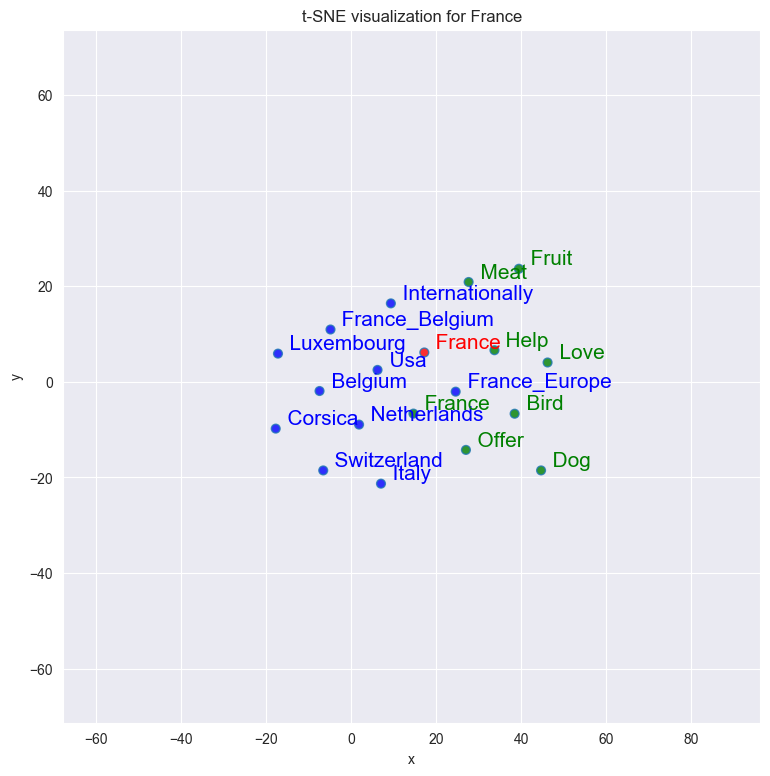

In [124]:
tsnescatterplot(base_model, 'france', ['dog', 'bird', 'offer', 'help', 'france', 'fruit', 'meat', 'love'])